In [1]:
import torch
import torchphysics as tp
import time
X = tp.spaces.Z3("x")
box = tp.domains.Box(X, [0, 0, 0], 5, 8, 6)

T = tp.spaces.R1("t")
inter = tp.domains.Interval(T, 0, 1)

In [2]:
A = torch.randn((10, 2))
A

tensor([[-0.3518,  0.9640],
        [ 0.4983, -1.0390],
        [ 1.3179,  0.9914],
        [ 0.8997,  0.8020],
        [ 1.3922,  0.0425],
        [ 0.2808, -1.8138],
        [-0.8788,  0.4868],
        [ 1.4442,  1.6074],
        [ 0.0344, -2.0857],
        [ 0.3565, -0.0058]])

In [3]:
torch.round(A).dtype

torch.float32

In [4]:
box.volume()

tensor([[240.]])

In [5]:
box.bounding_box()

tensor([0., 5., 0., 8., 0., 6.])

1000

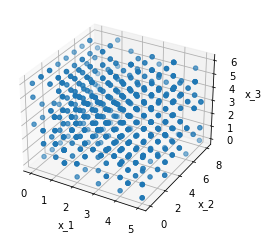

In [6]:
box_sampler = tp.samplers.RandomUniformSampler(box, 1000)
fig = tp.utils.scatter(X, box_sampler)
len(box_sampler.sample_points().as_tensor)

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


5000

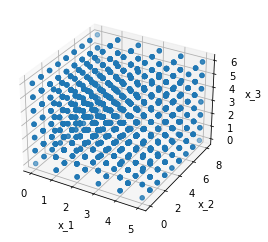

In [7]:
box_sampler = tp.samplers.GridSampler(box, 5000)
fig = tp.utils.scatter(X, box_sampler)
len(box_sampler.sample_points().as_tensor)

In [8]:
ppp = box_sampler.sample_points()
print(ppp.as_tensor.shape)
torch.all(box._contains(ppp))

torch.Size([5000, 3])


tensor(True)

1000

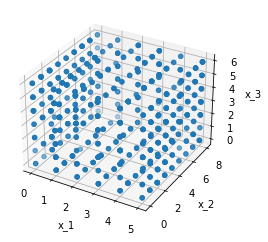

In [11]:
box_sampler_bc = tp.samplers.RandomUniformSampler(box.boundary, 1000)
fig = tp.utils.scatter(X, box_sampler_bc)
len(box_sampler_bc.sample_points().as_tensor)

In [100]:
ppp = box_sampler_bc.sample_points()
torch.all(box.boundary._contains(ppp))

tensor(True)

In [101]:
ppp

Points:
{'x': tensor([[2.0000, 1.5478, 1.0471],
        [2.0000, 0.5853, 3.6962],
        [0.0000, 0.8237, 1.0059],
        ...,
        [1.9419, 3.9521, 0.0000],
        [1.0774, 3.4750, 6.0000],
        [0.7094, 3.8854, 0.0000]])}

In [102]:
box.boundary.normal(ppp)

tensor([[ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [-1.,  0.,  0.],
        ...,
        [ 0.,  0., -1.],
        [ 0.,  0.,  1.],
        [ 0.,  0., -1.]])

1000

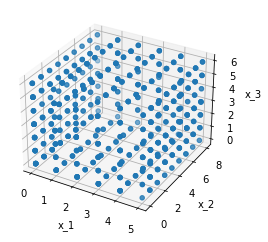

In [12]:
box_sampler_bc = tp.samplers.GridSampler(box.boundary, 1000)
fig = tp.utils.scatter(X, box_sampler_bc)
len(box_sampler_bc.sample_points().as_tensor)

In [104]:
ppp = box_sampler_bc.sample_points()
torch.all(box.boundary._contains(ppp))

tensor(True)

In [105]:
# def grad_fn(u, x, t):
#     lap = tp.utils.laplacian(u, x)
#     grad = tp.utils.grad(u, x)
#     grad_t = tp.utils.grad(u, t)
#     return lap + grad[:, :1]**2 - grad_t

# grad_compiled = torch.compile(grad_fn)

In [106]:
# import torch._dynamo
# torch._dynamo.reset()


# batch = 500000

# model = tp.models.FCN(X*T, U, hidden=(50, 50, 50, 50, 50))
# model = model.to("cuda:0")
# values = torch.rand((batch, 2), requires_grad=True, device="cuda:0")
# values_t = torch.rand((batch, 1), requires_grad=True, device="cuda:0")
# input_value = tp.spaces.Points(torch.column_stack((values, values_t)), X*T)
# output_value = model(input_value).as_tensor
# print("Normal speed")
# start_time = time.time()
# grad_fn(output_value, values, values_t)
# print("Took:", time.time() - start_time)
# print("Compiled speed")
# start_time = time.time()
# grad_compiled(output_value, values, values_t)
# print("Took:", time.time() - start_time)

In [107]:
import torchphysics as tp

D = tp.spaces.Rn("x", 4)
h_cube = tp.domains.HyperCube(D, 3, 4)
h_cube.volume()

tensor([[1.]])

In [108]:
hyper_sampler = tp.samplers.RandomUniformSampler(h_cube, 100)
hyper_sampler.sample_points().as_tensor.shape

torch.Size([100, 4])